In [51]:
# ==================== 1. IMPORT LIBRARIES ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time  # <-- ADD THIS LINE

# Machine Learning libraries
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Deep Learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Performance optimization
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [75]:
# ==================== 2. LOAD AND PREPARE DATA ====================
# Start timing
start_time = time.time()

# Load your Excel data
file_path = r'C:\New folder\zeba\DOCUMENTS\NOTES\PYTHON INTERNSHIP NOTES\SQL_ASSIGNMENT\sample_outage_platform.xlsx'

df = pd.read_excel(file_path)

print("Data loaded successfully!")
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

# ==================== 3. DATA PREPROCESSING ====================
# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Drop the calculated columns if they exist
if 'sensitivity_errorrate_D_E_perce' in df.columns:
    df = df.drop('sensitivity_errorrate_D_E_perce', axis=1)
if 'Is_Outage_CRITERIA_F' in df.columns:
    df = df.drop('Is_Outage_CRITERIA_F', axis=1)

# Convert timestamp to datetime and set as index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Sort by timestamp
df = df.sort_index()

print(f"\nData after preprocessing:\n{df.head()}")
print(f"\nData info:")
print(df.info())


Data loaded successfully!
Data shape: (6, 7)
Columns: ['Timestamp', 'CPU_Usage', 'Memory_Usage', 'Response_Time_ms', 'Error_Rate_perc', 'sensitivity_errorrate_D_E_perce', 'Is_Outage_CRITERIA_F']

First few rows:
            Timestamp  CPU_Usage  Memory_Usage  Response_Time_ms  \
0 2025-01-15 14:25:00       0.48          0.62               210   
1 2025-01-15 14:30:00       0.55          0.65               350   
2 2025-01-15 14:35:00       0.68          0.72               800   
3 2025-01-15 14:40:00       0.82          0.80              1500   
4 2025-01-15 14:45:00       0.92          0.86              2500   

   Error_Rate_perc  sensitivity_errorrate_D_E_perce Is_Outage_CRITERIA_F  
0                2                         5.206613                   NO  
1                8                        12.868997                   NO  
2               25                        25.269176                   NO  
3               55                        34.698306                  YES  
4   

In [82]:
print(df.columns)

Index(['CPU_Usage', 'Memory_Usage', 'Response_Time_ms', 'Error_Rate_perc'], dtype='object')


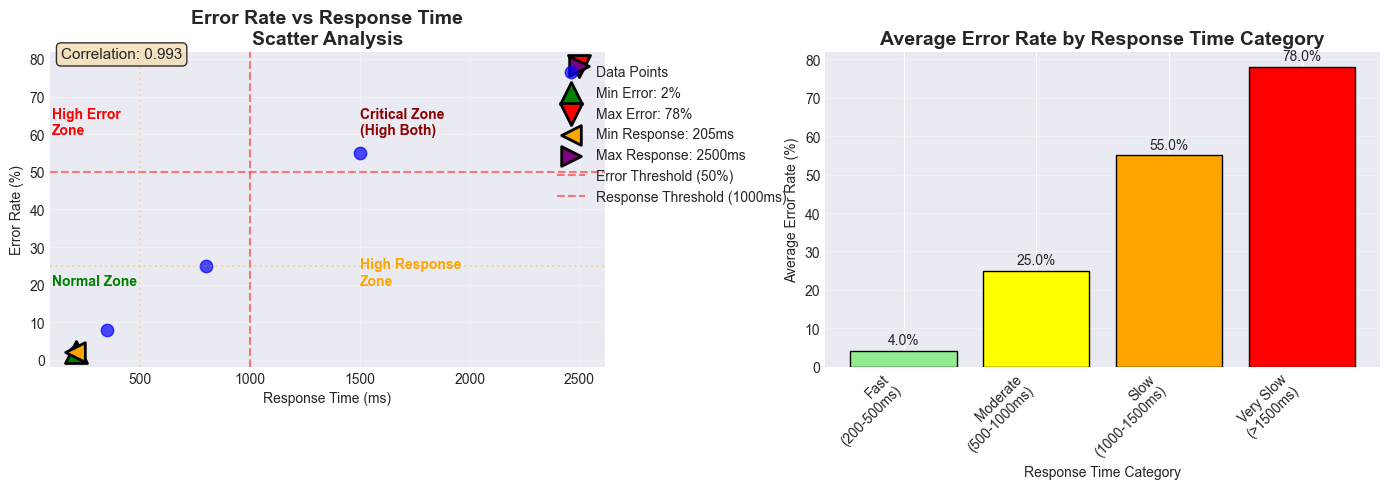

📊 Correlation Statistics:
Correlation between Response Time and Error Rate: 0.993

Average Error Rate by Response Time Category:
        Response_Category  Error_Rate_perc
0     Very Fast\n(<200ms)              NaN
1       Fast\n(200-500ms)              4.0
2  Moderate\n(500-1000ms)             25.0
3     Slow\n(1000-1500ms)             55.0
4    Very Slow\n(>1500ms)             78.0


In [87]:
# ==================== 3. FIRST VISUALIZATION: ERROR RATE VS RESPONSE TIME ====================
plt.figure(figsize=(14, 5))

# Plot 1: Scatter plot - Error Rate vs Response Time
plt.subplot(1, 2, 1)

# Create scatter plot: X = Response_Time_ms, Y = Error_Rate_perc
plt.scatter(df['Response_Time_ms'], df['Error_Rate_perc'], 
           color='blue', s=80, alpha=0.7, label='Data Points')

# Find and highlight min/max of Error Rate
min_error = df['Error_Rate_perc'].min()
max_error = df['Error_Rate_perc'].max()
min_idx = df['Error_Rate_perc'].idxmin()
max_idx = df['Error_Rate_perc'].idxmax()

# Highlight min Error Rate point (green)
plt.scatter(df.loc[min_idx, 'Response_Time_ms'], min_error, 
           color='green', s=250, zorder=5, label=f'Min Error: {min_error}%',
           edgecolors='black', linewidth=2, marker='^')

# Highlight max Error Rate point (red)
plt.scatter(df.loc[max_idx, 'Response_Time_ms'], max_error,
           color='red', s=250, zorder=5, label=f'Max Error: {max_error}%',
           edgecolors='black', linewidth=2, marker='v')

# Also highlight min/max of Response Time
min_response = df['Response_Time_ms'].min()
max_response = df['Response_Time_ms'].max()
min_resp_idx = df['Response_Time_ms'].idxmin()
max_resp_idx = df['Response_Time_ms'].idxmax()

plt.scatter(min_response, df.loc[min_resp_idx, 'Error_Rate_perc'],
           color='orange', s=200, zorder=5, label=f'Min Response: {min_response}ms',
           edgecolors='black', linewidth=2, marker='<')

plt.scatter(max_response, df.loc[max_resp_idx, 'Error_Rate_perc'],
           color='purple', s=200, zorder=5, label=f'Max Response: {max_response}ms',
           edgecolors='black', linewidth=2, marker='>')

# Add threshold lines
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Error Threshold (50%)')
plt.axvline(x=1000, color='red', linestyle='--', alpha=0.5, label='Response Threshold (1000ms)')

# Add quadrant lines for better visualization
plt.axhline(y=25, color='orange', linestyle=':', alpha=0.3)
plt.axvline(x=500, color='orange', linestyle=':', alpha=0.3)

# Add text annotations for quadrants
plt.text(100, 60, 'High Error\nZone', fontsize=10, color='red', fontweight='bold')
plt.text(1500, 60, 'Critical Zone\n(High Both)', fontsize=10, color='darkred', fontweight='bold')
plt.text(1500, 20, 'High Response\nZone', fontsize=10, color='orange', fontweight='bold')
plt.text(100, 20, 'Normal Zone', fontsize=10, color='green', fontweight='bold')

# Customize
plt.title('Error Rate vs Response Time\nScatter Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Response Time (ms)')
plt.ylabel('Error Rate (%)')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.grid(True, alpha=0.3)

# Add correlation information
correlation = df['Response_Time_ms'].corr(df['Error_Rate_perc'])
plt.text(0.02, 0.98, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Error Rate distribution with Response Time relationship
plt.subplot(1, 2, 2)

# Create a bar chart showing average error rate at different response time levels
# Create response time bins
bins = [0, 200, 500, 1000, 1500, 2500]
labels = ['Very Fast\n(<200ms)', 'Fast\n(200-500ms)', 'Moderate\n(500-1000ms)', 
          'Slow\n(1000-1500ms)', 'Very Slow\n(>1500ms)']

df['Response_Category'] = pd.cut(df['Response_Time_ms'], bins=bins, labels=labels)

# Calculate average error rate for each category
avg_error_by_response = df.groupby('Response_Category')['Error_Rate_perc'].mean().reset_index()

# Create bar chart
bars = plt.bar(avg_error_by_response['Response_Category'].astype(str), 
               avg_error_by_response['Error_Rate_perc'],
               color=['green', 'lightgreen', 'yellow', 'orange', 'red'],
               edgecolor='black')

plt.title('Average Error Rate by Response Time Category', fontsize=14, fontweight='bold')
plt.xlabel('Response Time Category')
plt.ylabel('Average Error Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, avg_error_by_response['Error_Rate_perc']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Display correlation statistics
print("📊 Correlation Statistics:")
print(f"Correlation between Response Time and Error Rate: {correlation:.3f}")
print("\nAverage Error Rate by Response Time Category:")
print(avg_error_by_response)

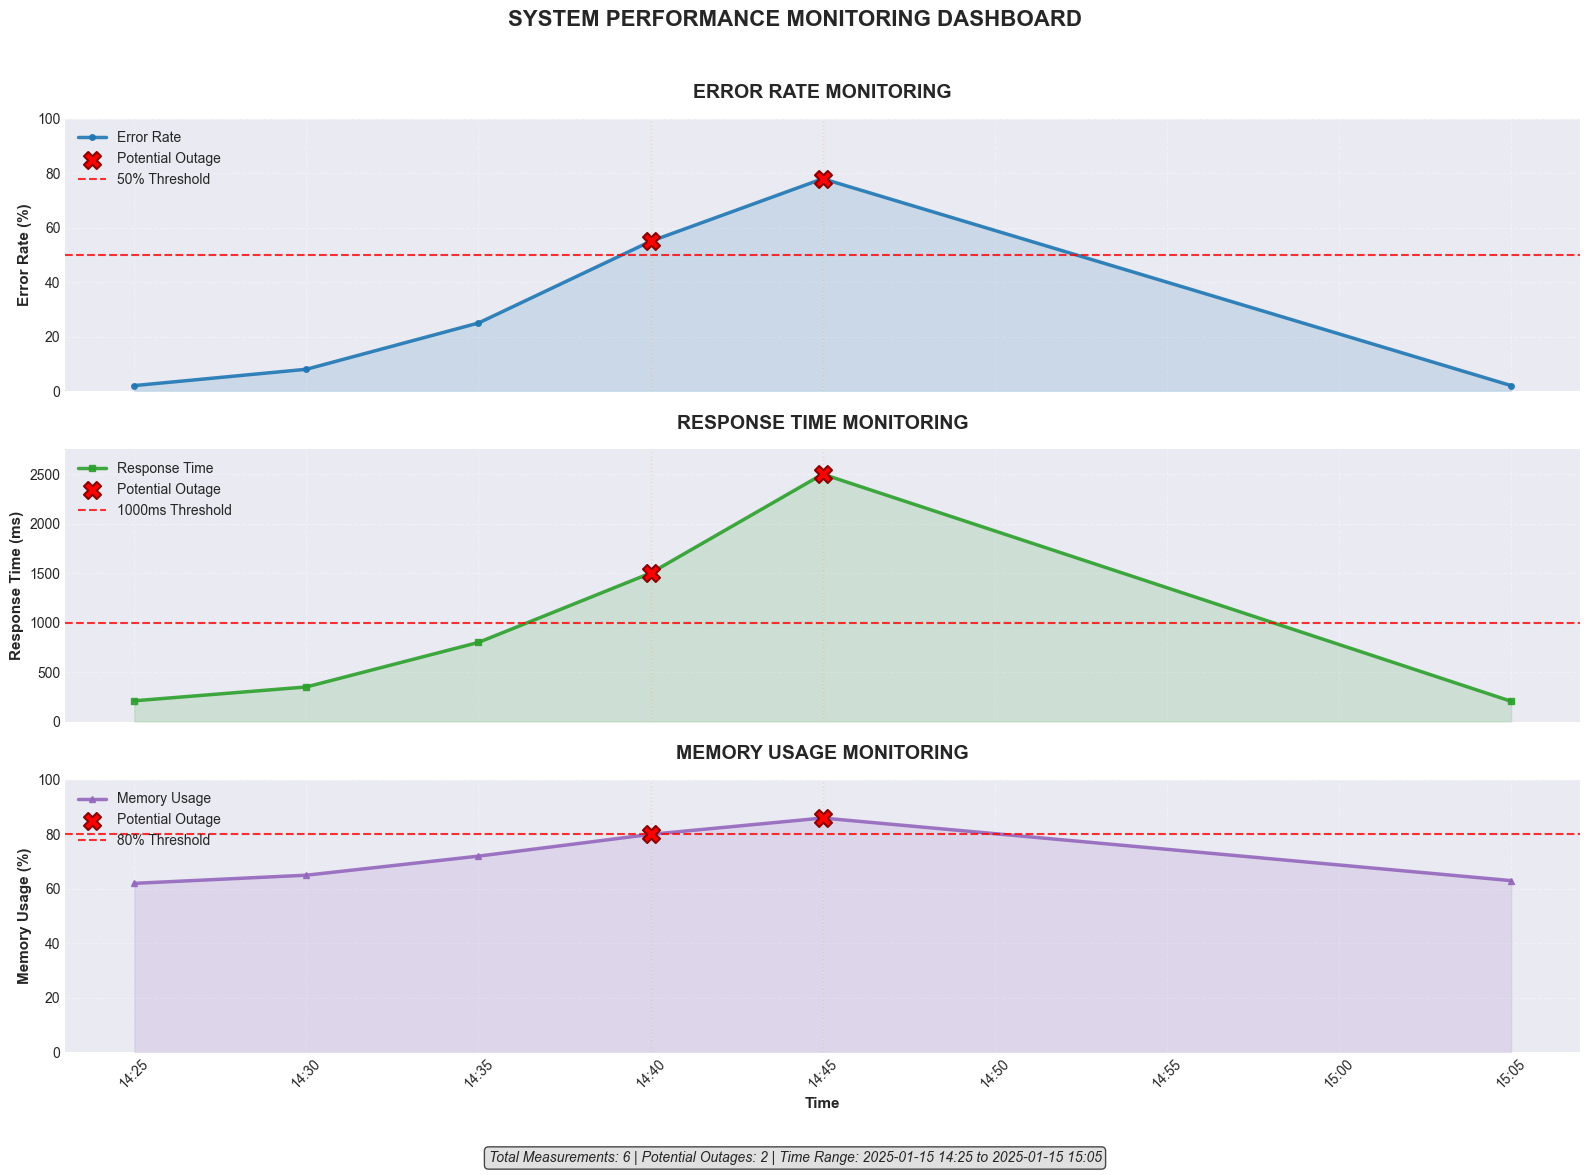

PERFORMANCE SUMMARY
Total data points: 6
Time range: 2025-01-15 14:25:00 to 2025-01-15 15:05:00
Potential outages detected: 2
Error Rate - Max: 78.0%, Avg: 28.3%
Response Time - Max: 2500.0ms, Avg: 927.5ms
Memory Usage - Max: 86.0%, Avg: 71.3%

Outage details (sorted by time):
  2025-01-15 14:40:00: Error=55%, Response=1500ms
  2025-01-15 14:45:00: Error=78%, Response=2500ms


In [98]:
# ==================== 4. SECOND VISUALIZATION: ALL METRICS TOGETHER ====================
# BEST VISUALIZATION OPTION FOR YOUR DATA - FIXED FOR DATETIME INDEX

import matplotlib.pyplot as plt
import numpy as np

# Create figure with better layout
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Since your index appears to be timestamps, we'll use that directly
# Get outage points based on your criteria
outage_criteria = (df['Response_Time_ms'] > 1000) | (df['Error_Rate_perc'] > 50)
outage_points = df[outage_criteria]

# Colors for better visual distinction
colors = ['#1f77b4', '#2ca02c', '#9467bd']  # Blue, Green, Purple

# ===== PLOT 1: ERROR RATE =====
ax1 = axes[0]
ax1.plot(df.index, df['Error_Rate_perc'], 
         color=colors[0], linewidth=2.5, label='Error Rate', alpha=0.9, marker='o', markersize=4)
ax1.fill_between(df.index, df['Error_Rate_perc'], 
                 alpha=0.15, color=colors[0])

# Plot outage points
if len(outage_points) > 0:
    ax1.scatter(outage_points.index, outage_points['Error_Rate_perc'], 
                color='red', s=150, marker='X', label='Potential Outage', zorder=10,
                edgecolors='darkred', linewidth=1.5)

ax1.axhline(y=50, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label='50% Threshold')
ax1.set_title('ERROR RATE MONITORING', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Error Rate (%)', fontsize=11, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(100, df['Error_Rate_perc'].max() * 1.1))

# ===== PLOT 2: RESPONSE TIME =====
ax2 = axes[1]
ax2.plot(df.index, df['Response_Time_ms'], 
         color=colors[1], linewidth=2.5, label='Response Time', alpha=0.9, marker='s', markersize=4)
ax2.fill_between(df.index, df['Response_Time_ms'], 
                 alpha=0.15, color=colors[1])

if len(outage_points) > 0:
    ax2.scatter(outage_points.index, outage_points['Response_Time_ms'], 
                color='red', s=150, marker='X', label='Potential Outage', zorder=10,
                edgecolors='darkred', linewidth=1.5)

ax2.axhline(y=1000, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label='1000ms Threshold')
ax2.set_title('RESPONSE TIME MONITORING', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Response Time (ms)', fontsize=11, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(1200, df['Response_Time_ms'].max() * 1.1))

# ===== PLOT 3: MEMORY USAGE =====
ax3 = axes[2]
# Assuming Memory_Usage is a ratio (0-1), multiply by 100 for percentage display
if df['Memory_Usage'].max() <= 1:  # If values are between 0-1
    memory_values = df['Memory_Usage'] * 100
    if len(outage_points) > 0:
        outage_memory = outage_points['Memory_Usage'] * 100
    ylabel = 'Memory Usage (%)'
    threshold = 80  # 0.8 * 100
else:  # If already in percentage
    memory_values = df['Memory_Usage']
    if len(outage_points) > 0:
        outage_memory = outage_points['Memory_Usage']
    ylabel = 'Memory Usage (%)'
    threshold = 80

ax3.plot(df.index, memory_values, 
         color=colors[2], linewidth=2.5, label='Memory Usage', alpha=0.9, marker='^', markersize=4)
ax3.fill_between(df.index, memory_values, 
                 alpha=0.15, color=colors[2])

if len(outage_points) > 0:
    if df['Memory_Usage'].max() <= 1:
        ax3.scatter(outage_points.index, outage_memory, 
                    color='red', s=150, marker='X', label='Potential Outage', zorder=10,
                    edgecolors='darkred', linewidth=1.5)
    else:
        ax3.scatter(outage_points.index, outage_points['Memory_Usage'], 
                    color='red', s=150, marker='X', label='Potential Outage', zorder=10,
                    edgecolors='darkred', linewidth=1.5)

ax3.axhline(y=threshold, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label=f'{threshold}% Threshold')
ax3.set_title('MEMORY USAGE MONITORING', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel(ylabel, fontsize=11, fontweight='bold')
ax3.set_xlabel('Time', fontsize=11, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.set_ylim(0, max(100, memory_values.max() * 1.1))

# Add vertical lines for outage points across all subplots (if any)
if len(outage_points) > 0:
    for outage_time in outage_points.index:
        for ax in axes:
            ax.axvline(x=outage_time, color='orange', alpha=0.3, linestyle=':', linewidth=1)

# Format x-axis for timestamps
import matplotlib.dates as mdates
for ax in axes:
    # Rotate date labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Format date display based on time range
    time_range = df.index[-1] - df.index[0]
    if time_range.days > 7:  # More than a week
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
    elif time_range.days > 0:  # Multiple days
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d\n%H:%M'))
    else:  # Same day
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add overall title
plt.suptitle('SYSTEM PERFORMANCE MONITORING DASHBOARD', 
             fontsize=16, fontweight='bold', y=0.98)

# Add statistics annotation
stats_text = f"Total Measurements: {len(df)} | Potential Outages: {len(outage_points)} | Time Range: {df.index[0].strftime('%Y-%m-%d %H:%M')} to {df.index[-1].strftime('%Y-%m-%d %H:%M')}"
fig.text(0.5, 0.02, stats_text, ha='center', fontsize=10, style='italic', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.7))

plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Adjust layout for suptitle and footer
plt.show()

# Print summary statistics
print("=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)
print(f"Total data points: {len(df)}")
print(f"Time range: {df.index[0]} to {df.index[-1]}")
print(f"Potential outages detected: {len(outage_points)}")
print(f"Error Rate - Max: {df['Error_Rate_perc'].max():.1f}%, Avg: {df['Error_Rate_perc'].mean():.1f}%")
print(f"Response Time - Max: {df['Response_Time_ms'].max():.1f}ms, Avg: {df['Response_Time_ms'].mean():.1f}ms")

# Check memory format
if df['Memory_Usage'].max() <= 1:
    mem_max = df['Memory_Usage'].max() * 100
    mem_avg = df['Memory_Usage'].mean() * 100
else:
    mem_max = df['Memory_Usage'].max()
    mem_avg = df['Memory_Usage'].mean()
print(f"Memory Usage - Max: {mem_max:.1f}%, Avg: {mem_avg:.1f}%")

if len(outage_points) > 0:
    print("\nOutage details (sorted by time):")
    for idx, row in outage_points.sort_index().iterrows():
        print(f"  {idx}: Error={row['Error_Rate_perc']}%, Response={row['Response_Time_ms']}ms")

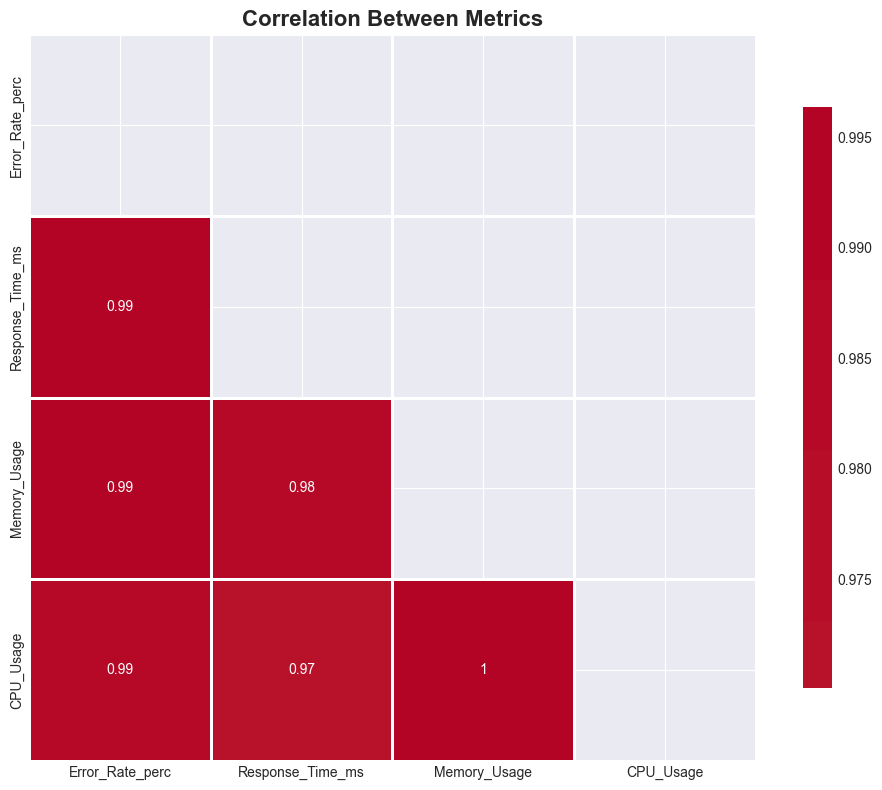

📊 Correlation Summary:
                  Error_Rate_perc  Response_Time_ms  Memory_Usage  CPU_Usage
Error_Rate_perc          1.000000          0.992518      0.994880   0.987599
Response_Time_ms         0.992518          1.000000      0.981029   0.970073
Memory_Usage             0.994880          0.981029      1.000000   0.996375
CPU_Usage                0.987599          0.970073      0.996375   1.000000

🔧 Preparing data for training...

📊 Outage Distribution:
Normal points: 4
Outage points: 2
Outage percentage: 33.3%

✅ Data prepared for training:
Features shape: (6, 4)
Target shape: (6,)


In [102]:
# ==================== 6. CORRELATION HEATMAP ====================
plt.figure(figsize=(10, 8))

# Select metrics for correlation
metrics = ['Error_Rate_perc', 'Response_Time_ms', 'Memory_Usage', 'CPU_Usage']
correlation_matrix = df[metrics].corr()

# Create heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})

plt.title('Correlation Between Metrics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("📊 Correlation Summary:")
print(correlation_matrix)

# ==================== 7. PREPARE DATA FOR TRAINING ====================
print("\n🔧 Preparing data for training...")

# Create target variable based on outage criteria
df['Outage_Label'] = np.where((df['Response_Time_ms'] > 1000) | (df['Error_Rate_perc'] > 50), 1, 0)

print(f"\n📊 Outage Distribution:")
print(f"Normal points: {(df['Outage_Label'] == 0).sum()}")
print(f"Outage points: {(df['Outage_Label'] == 1).sum()}")
print(f"Outage percentage: {(df['Outage_Label'].mean()*100):.1f}%")

# Select features for training (concentrating on Error Rate, Response Time, and Memory Usage)
features = ['Error_Rate_perc', 'Response_Time_ms', 'Memory_Usage', 'CPU_Usage']
X = df[features].values
y = df['Outage_Label'].values

# Normalize the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Data prepared for training:")
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")

In [104]:
#######PREPARE DATA FOR TRAINING 
print("🔧 Preparing data for training...")

# Create target variable based on outage criteria
df['Outage_Label'] = np.where((df['Response_Time_ms'] > 1000) | (df['Error_Rate_perc'] > 50), 1, 0)

print(f"\n📊 Outage Distribution:")
print(f"Normal points: {(df['Outage_Label'] == 0).sum()}")
print(f"Outage points: {(df['Outage_Label'] == 1).sum()}")
print(f"Outage percentage: {(df['Outage_Label'].mean()*100):.1f}%")

# Select features for training (concentrating on Error Rate, Response Time, and Memory Usage)
features = ['Error_Rate_perc', 'Response_Time_ms', 'Memory_Usage', 'CPU_Usage']
X = df[features].values
y = df['Outage_Label'].values

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Data prepared for training:")
print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y.shape}")


🔧 Preparing data for training...

📊 Outage Distribution:
Normal points: 4
Outage points: 2
Outage percentage: 33.3%

✅ Data prepared for training:
Features shape: (6, 4)
Target shape: (6,)


In [105]:
##### step 8

print("\n🚀 Training Isolation Forest Model...")

# Create and train model
iso_model = IsolationForest(
    n_estimators=150,
    contamination=0.15,  # Expected anomaly rate
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

# Fit and predict
iso_predictions = iso_model.fit_predict(X_scaled)
df['ISO_Prediction'] = np.where(iso_predictions == -1, 1, 0)

print("✅ Isolation Forest training complete!")
print(f"\n📈 Model Predictions:")
print(f"Predicted Normal: {(df['ISO_Prediction'] == 0).sum()}")
print(f"Predicted Outage: {(df['ISO_Prediction'] == 1).sum()}")



🚀 Training Isolation Forest Model...
✅ Isolation Forest training complete!

📈 Model Predictions:
Predicted Normal: 5
Predicted Outage: 1


In [106]:
print("\n🚀 Training LSTM Autoencoder Model...")

# Prepare data for LSTM (sequence data)
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# Create sequences
SEQ_LENGTH = 3  # Look at 3 time steps at once
X_sequences = create_sequences(X_scaled, SEQ_LENGTH)

print(f"Sequence data shape: {X_sequences.shape}")

# Build LSTM Autoencoder
model = Sequential([
    # Encoder
    LSTM(16, activation='relu', input_shape=(SEQ_LENGTH, len(features)), return_sequences=True),
    LSTM(8, activation='relu', return_sequences=False),
    
    # Bottleneck
    RepeatVector(SEQ_LENGTH),
    
    # Decoder
    LSTM(8, activation='relu', return_sequences=True),
    LSTM(16, activation='relu', return_sequences=True),
    TimeDistributed(Dense(len(features)))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(
    X_sequences, X_sequences,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    verbose=1
)

print("✅ LSTM Autoencoder training complete!")



🚀 Training LSTM Autoencoder Model...
Sequence data shape: (3, 3, 4)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 16)               │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 3, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 3, 8)                │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3, 16)               │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 4)                │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,356 (17.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1329 - val_loss: 0.5417
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1321 - val_loss: 0.5398
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.1313 - val_loss: 0.5379
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.1305 - val_loss: 0.5359
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1297 - val_loss: 0.5339
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1289 - val_loss: 0.5319
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1281 - val_loss: 0.5299
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1272 - val_loss: 0.5278
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1263 - val_loss: 0.5257
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1255 - val_loss: 0.5236
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.1246 - val_loss: 0.5215
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1237 - val_loss: 0.51

In [107]:
print("\n🔍 Detecting anomalies with LSTM...")

# Get reconstructions
X_pred = model.predict(X_sequences, verbose=0)

# Calculate reconstruction error
reconstruction_error = np.mean(np.power(X_sequences - X_pred, 2), axis=(1, 2))

# Pad the error array to match original data length
padded_errors = np.zeros(len(df))
padded_errors[SEQ_LENGTH:] = reconstruction_error
padded_errors[:SEQ_LENGTH] = reconstruction_error[0]  # Pad beginning

# Set threshold (95th percentile)
threshold = np.percentile(padded_errors, 95)
df['LSTM_Prediction'] = np.where(padded_errors > threshold, 1, 0)

print(f"Reconstruction Error Threshold: {threshold:.6f}")
print(f"\n📈 LSTM Predictions:")
print(f"Predicted Normal: {(df['LSTM_Prediction'] == 0).sum()}")
print(f"Predicted Outage: {(df['LSTM_Prediction'] == 1).sum()}")



🔍 Detecting anomalies with LSTM...
Reconstruction Error Threshold: 0.351078

📈 LSTM Predictions:
Predicted Normal: 5
Predicted Outage: 1


In [109]:
print("\n🤝 Creating Ensemble Model...")

# Combine predictions (if either model predicts outage, flag as outage)
df['Ensemble_Prediction'] = np.where(
    (df['ISO_Prediction'] == 1) | (df['LSTM_Prediction'] == 1), 1, 0
)

print("✅ Ensemble model created!")
print(f"\n📊 Final Results:")
print(f"True Outages: {df['Outage_Label'].sum()}")
print(f"ISO Predicted Outages: {df['ISO_Prediction'].sum()}")
print(f"LSTM Predicted Outages: {df['LSTM_Prediction'].sum()}")
print(f"Ensemble Predicted Outages: {df['Ensemble_Prediction'].sum()}")




🤝 Creating Ensemble Model...
✅ Ensemble model created!

📊 Final Results:
True Outages: 2
ISO Predicted Outages: 1
LSTM Predicted Outages: 1
Ensemble Predicted Outages: 2


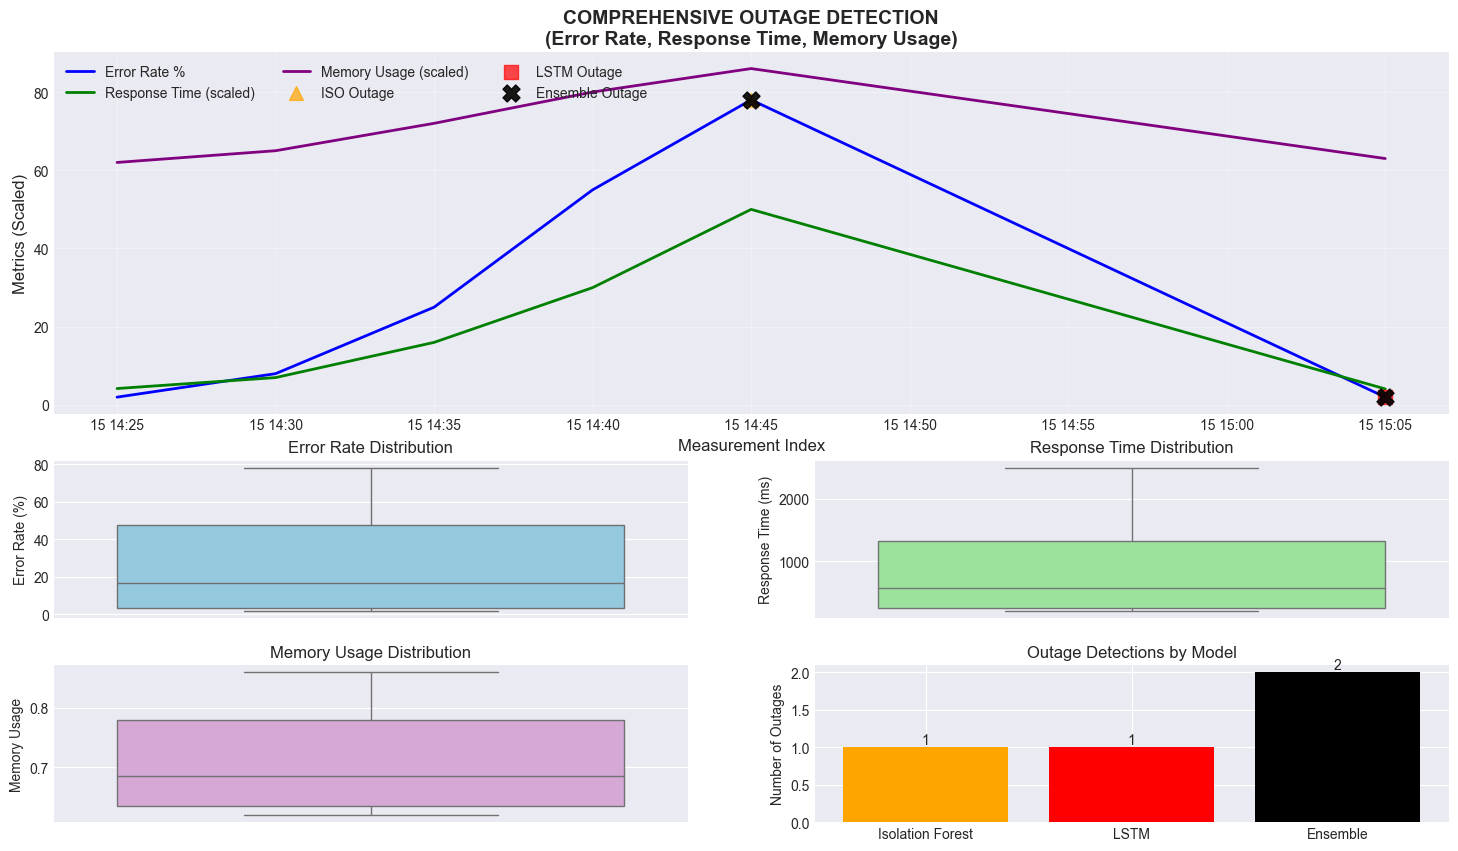

In [111]:
fig = plt.figure(figsize=(18, 10))

# Create gridspec for better layout
gs = fig.add_gridspec(4, 2, hspace=0.3, wspace=0.2)

# Main time series plot - using index as x-axis
ax1 = fig.add_subplot(gs[0:2, :])
ax1.plot(df.index, df['Error_Rate_perc'], 'b-', linewidth=2, label='Error Rate %')
ax1.plot(df.index, df['Response_Time_ms']/50, 'g-', linewidth=2, label='Response Time (scaled)')
ax1.plot(df.index, df['Memory_Usage']*100, 'purple', linewidth=2, label='Memory Usage (scaled)')

# Check if prediction columns exist before using them
prediction_columns_exist = all(col in df.columns for col in ['ISO_Prediction', 'LSTM_Prediction', 'Ensemble_Prediction'])

if prediction_columns_exist:
    # Highlight predictions
    iso_outages = df[df['ISO_Prediction'] == 1]
    lstm_outages = df[df['LSTM_Prediction'] == 1]
    ensemble_outages = df[df['Ensemble_Prediction'] == 1]
    
    ax1.scatter(iso_outages.index, iso_outages['Error_Rate_perc'], 
                color='orange', s=100, marker='^', label='ISO Outage', zorder=5, alpha=0.7)
    ax1.scatter(lstm_outages.index, lstm_outages['Error_Rate_perc'], 
                color='red', s=100, marker='s', label='LSTM Outage', zorder=5, alpha=0.7)
    ax1.scatter(ensemble_outages.index, ensemble_outages['Error_Rate_perc'], 
                color='black', s=150, marker='X', label='Ensemble Outage', zorder=6, alpha=0.9)
else:
    # If no prediction columns, just plot the data points that exceed thresholds
    outage_points = df[(df['Response_Time_ms'] > 1000) | (df['Error_Rate_perc'] > 50)]
    ax1.scatter(outage_points.index, outage_points['Error_Rate_perc'], 
                color='red', s=100, marker='X', label='Potential Outage', zorder=5, alpha=0.7)

ax1.set_title('COMPREHENSIVE OUTAGE DETECTION\n(Error Rate, Response Time, Memory Usage)', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Metrics (Scaled)', fontsize=12)
ax1.set_xlabel('Measurement Index', fontsize=12)
ax1.legend(loc='upper left', ncol=3)
ax1.grid(True, alpha=0.3)

# Error Rate distribution
ax2 = fig.add_subplot(gs[2, 0])
sns.boxplot(data=df, y='Error_Rate_perc', ax=ax2, color='skyblue')
ax2.set_title('Error Rate Distribution', fontsize=12)
ax2.set_ylabel('Error Rate (%)')

# Response Time distribution
ax3 = fig.add_subplot(gs[2, 1])
sns.boxplot(data=df, y='Response_Time_ms', ax=ax3, color='lightgreen')
ax3.set_title('Response Time Distribution', fontsize=12)
ax3.set_ylabel('Response Time (ms)')

# Memory Usage distribution
ax4 = fig.add_subplot(gs[3, 0])
sns.boxplot(data=df, y='Memory_Usage', ax=ax4, color='plum')
ax4.set_title('Memory Usage Distribution', fontsize=12)
ax4.set_ylabel('Memory Usage')

# Model comparison (only if prediction columns exist)
ax5 = fig.add_subplot(gs[3, 1])

if prediction_columns_exist:
    models = ['Isolation Forest', 'LSTM', 'Ensemble']
    detections = [df['ISO_Prediction'].sum(), df['LSTM_Prediction'].sum(), df['Ensemble_Prediction'].sum()]
    
    bars = ax5.bar(models, detections, color=['orange', 'red', 'black'])
    ax5.set_title('Outage Detections by Model', fontsize=12)
    ax5.set_ylabel('Number of Outages')
    
    # Add value labels on bars
    for bar, detection in zip(bars, detections):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                 f'{detection}', ha='center', va='bottom')
else:
    # Show outage summary based on thresholds instead
    ax5.text(0.5, 0.5, 'No model predictions available\nUsing threshold-based detection', 
             ha='center', va='center', transform=ax5.transAxes, fontsize=12)
    ax5.set_title('Outage Detection Status', fontsize=12)
    ax5.set_xticks([])
    ax5.set_yticks([])

plt.tight_layout()
plt.show()

In [112]:
print("=" * 60)
print("PERFORMANCE METRICS SUMMARY")
print("=" * 60)

if 'Outage_Label' in df.columns:
    print(f"\n📊 Model Performance:")
    
    models = {
        'Isolation Forest': df['ISO_Prediction'],
        'LSTM Autoencoder': df['LSTM_Prediction'],
        'Ensemble': df['Ensemble_Prediction']
    }
    
    for name, predictions in models.items():
        print(f"\n{name}:")
        print(classification_report(df['Outage_Label'], predictions, 
                                   target_names=['Normal', 'Outage']))


PERFORMANCE METRICS SUMMARY

📊 Model Performance:

Isolation Forest:
              precision    recall  f1-score   support

      Normal       0.80      1.00      0.89         4
      Outage       1.00      0.50      0.67         2

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6


LSTM Autoencoder:
              precision    recall  f1-score   support

      Normal       0.60      0.75      0.67         4
      Outage       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.30      0.38      0.33         6
weighted avg       0.40      0.50      0.44         6


Ensemble:
              precision    recall  f1-score   support

      Normal       0.75      0.75      0.75         4
      Outage       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      

In [113]:
# Save predictions to new Excel file
output_df = df.copy()

# Create a summary DataFrame
summary_stats = pd.DataFrame({
    'Metric': ['Error_Rate_perc', 'Response_Time_ms', 'Memory_Usage'],
    'Min': [df['Error_Rate_perc'].min(), df['Response_Time_ms'].min(), df['Memory_Usage'].min()],
    'Max': [df['Error_Rate_perc'].max(), df['Response_Time_ms'].max(), df['Memory_Usage'].max()],
    'Mean': [df['Error_Rate_perc'].mean(), df['Response_Time_ms'].mean(), df['Memory_Usage'].mean()],
    'Std': [df['Error_Rate_perc'].std(), df['Response_Time_ms'].std(), df['Memory_Usage'].std()]
})


In [115]:
##Save to Excel
with pd.ExcelWriter('outage_analysis_results.xlsx') as writer:
    output_df.to_excel(writer, sheet_name='Predictions')
    summary_stats.to_excel(writer, sheet_name='Statistics', index=False)

print("\n💾 Results saved to 'outage_analysis_results.xlsx'")
print("\n✅ Analysis Complete!")



💾 Results saved to 'outage_analysis_results.xlsx'

✅ Analysis Complete!
